# COMP5329 - Deep Learning

## Tutorial 11 - Deep Learning Applications

adin6536@uni.sydney.edu.au

**Semester 1, 2022**

**Objectives:**

* To learn about the Dataloader and Dataset API in Pytorch
* To learn about how to fine-tune a pre-trained model using custom dataset.

**Instructions:**

* Exercises to be completed on IPython notebook such as web-based TMPNB Ipython notebook(https://tmpnb.org).
* Go to File->Open. Drag and drop "Deep_Learning_Applications.ipynb"(with '') file to the home interface and click upload.
* To run the cell you can press Ctrl-Enter or hit the Play button at the top.

This tutorial is partially adapted from PyTorch's official tutorial.

Lecturers: Chang Xu

Tutors:




1. Discriminative task P(Y|X)

Object detection (detect the box outside of object)

Instance segmentation (bounding lines for the object)


2. Generative task P(X), P(X|Y)

## RCNN

### Selective Search

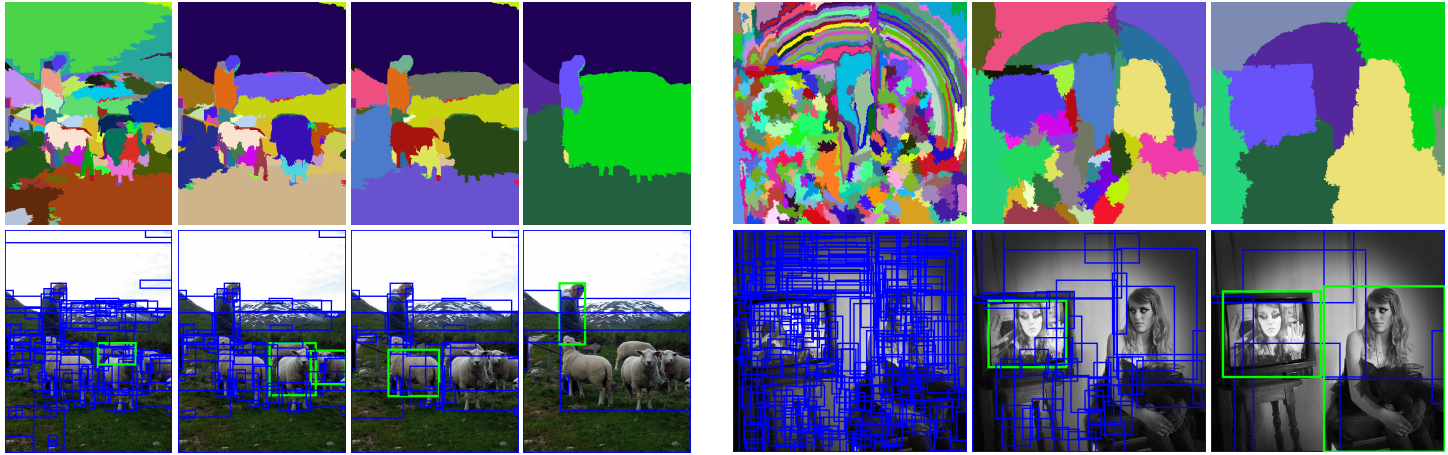

1. Capture all scales. (from small to large)
2. Group by regions by different metrics:
> * Color similarity
> * Texture similarity
> * Fill similarity
> * Size similarity
(https://www.geeksforgeeks.org/selective-search-for-object-detection-r-cnn/)






![image.png](https://media.geeksforgeeks.org/wp-content/uploads/20200128130724/Step2.PNG)

3. Propose regions on different scales

![image.png](https://media.geeksforgeeks.org/wp-content/uploads/20200128135031/step3.PNG)

### Pretrained CNN on classification task

Mostly Resnet50

### Full model

![image.png](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*REPHY47zAyzgbNKC6zlvBQ.png)

## Fast-RCNN

1. Replace feeding regions -> feeding the whole image -> feature maps
2. Selective search on feature map space
3. Replace the head of pretrained CNN by ROI pooling layer + different loss

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*0pMP3aY8blSpva5tvWbnKA.png)

Cls, BB

Cls: [0, 0, 0, 1, 0]

BB: [x, y, w, h]

x_min, y_min, x_max, y_max

x_min, y_min, w, h

## Faster-RCNN

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*pSnVmJCyQIRKHDPt3cfnXA.png)



RPN(FM) -> Batchsize, B, N, x, y, h, w

B, N, x , y, h, w

C, B
C: number of classes
0, 0, 0, 1
B: x, y, h, w

## Mask-RCNN

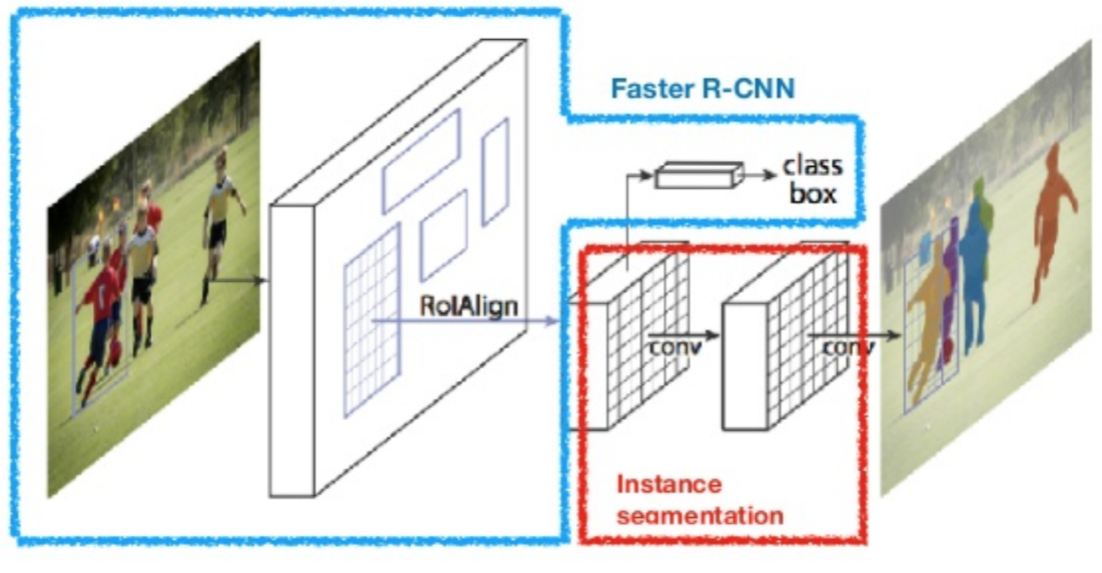

#AI AI AI

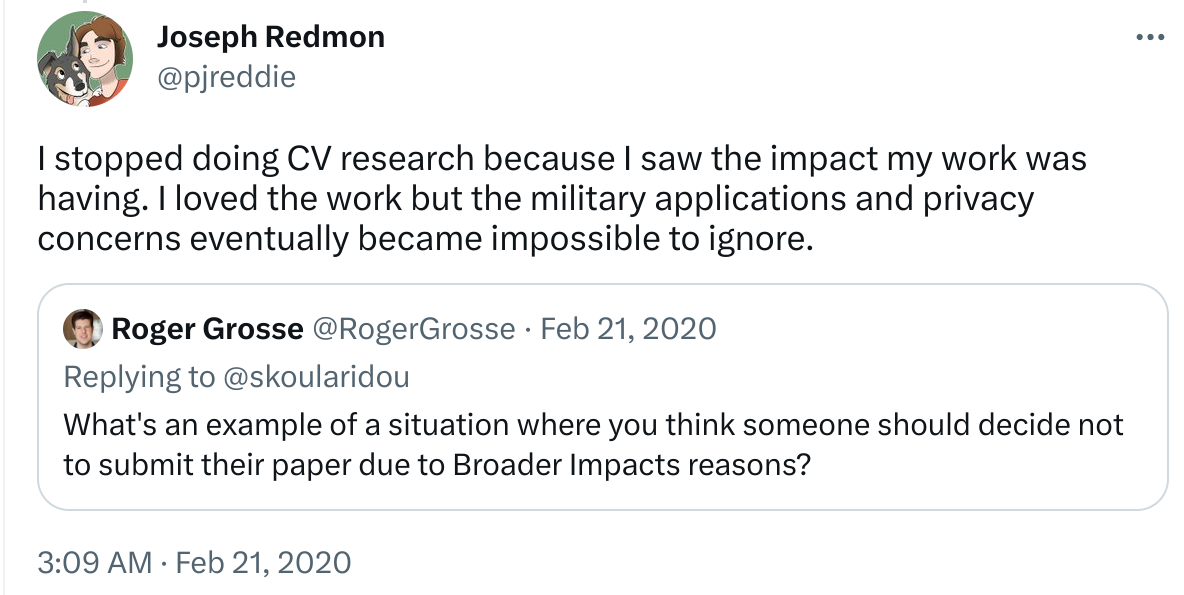

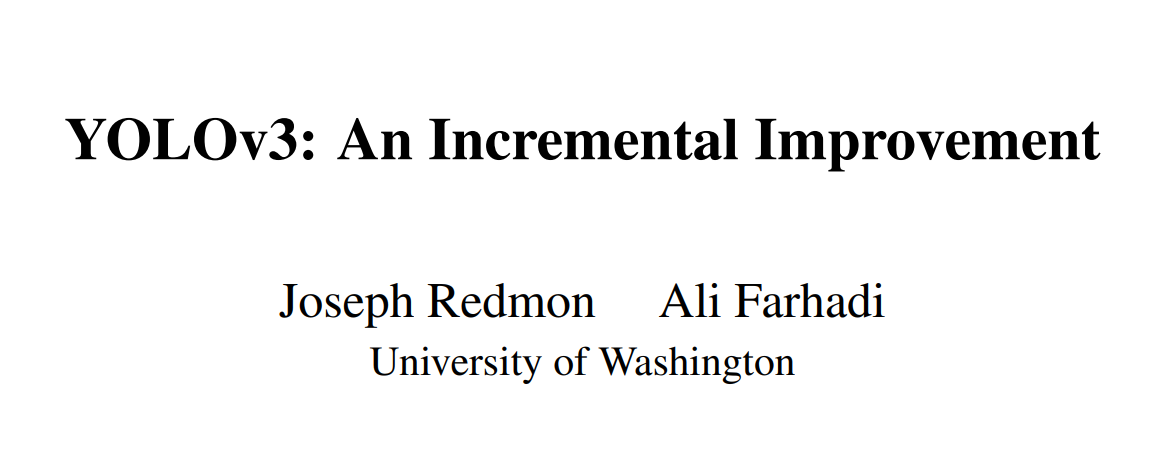

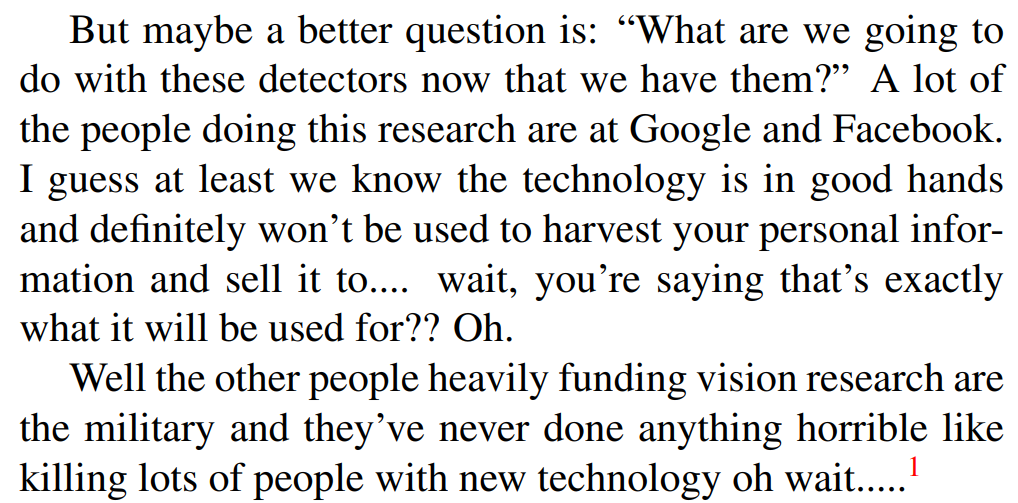

## What we will do with the object detectors?

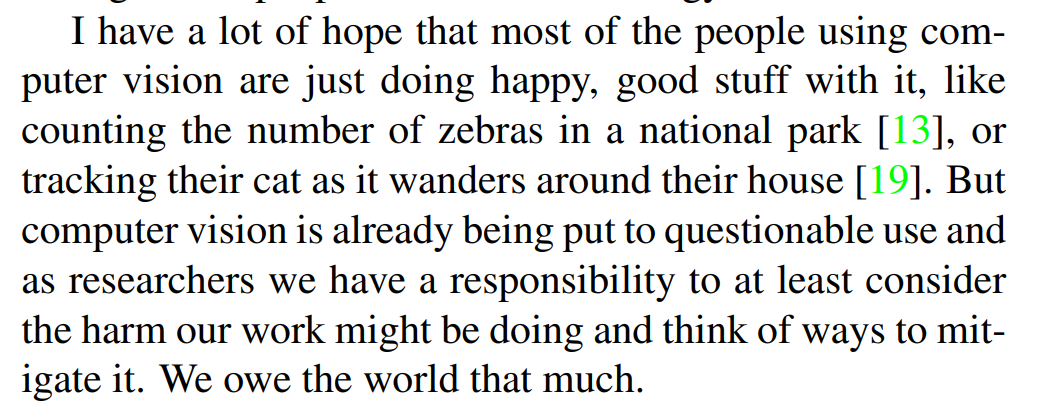

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

In this tutorial, we are using a dataset named PennFudan dataset, this dataset is available at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip.
We are going to make implement a class to encapsulate it, and implement the necessary functions.



In [ ]:
%%shell

pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip


  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-9m2b8t5f
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-9m2b8t5f
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375614 sha256=8a89ff2049c91bc5145487233a93787b0262279ed902a4747e87196287ee3e68
  Stored in directory: /tmp/pip-ephem-wheel-cache-e7ck33d1/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.7
    Uninstalling pycocotools-2.0.7:
      Successfully uninstalled pycocotools-2.0.7
--2024-05-16 09:50:17--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69

In [ ]:
%%shell

pip install torch==1.13.0 torchvision



Here is one example of an image in the dataset

In [ ]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00005.png')

and its corresponding instance segmentation mask

In [ ]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00005_mask.png')
mask.convert('P')
mask.putpalette([
    0, 0, 0,
    255, 0, 0,
    255, 255, 0,
    255, 153, 0,
])
mask

So each image has a corresponding segmentation mask, where each color correspond to a different instance.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

In [ ]:
img_path = 'PennFudanPed/PNGImages/FudanPed00005.png'
mask_path = 'PennFudanPed/PedMasks/FudanPed00005_mask.png'
img = Image.open(img_path).convert("RGB")
mask = Image.open(mask_path)

mask = np.array(mask)
obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of binary masks
masks = mask == obj_ids[:, None, None]

In [ ]:
obj_ids[:, None, None]

In [ ]:
mask.shape

In [ ]:
masks.shape

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # assume all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

If you are not familiar with these two models, it's a good time to review the lecture slides.

We will download a pre-trained Mask R-CNN and fine tune it using our PennFudan dataset.


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions
Luckily, Pytorch provides some very useful helper function for us. Let's use them


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# Define the pipeline of the transformations for each image.
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together



In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# dataset splitting
# torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [ ]:
# dynamically determine the device which will be used to train.
# use gpu if we have one.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

model = get_instance_segmentation_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# we want to decrease the learning rate by 0.1 every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Let's train the model for 10 epochs

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:52:07  lr: 0.000090  loss: 3.5078 (3.5078)  loss_classifier: 0.5717 (0.5717)  loss_box_reg: 0.2185 (0.2185)  loss_mask: 2.7038 (2.7038)  loss_objectness: 0.0121 (0.0121)  loss_rpn_box_reg: 0.0018 (0.0018)  time: 52.1311  data: 0.4275  max mem: 0
Epoch: [0]  [10/60]  eta: 0:42:14  lr: 0.000936  loss: 1.5262 (1.9529)  loss_classifier: 0.4140 (0.3990)  loss_box_reg: 0.2560 (0.2808)  loss_mask: 0.9118 (1.2483)  loss_objectness: 0.0151 (0.0192)  loss_rpn_box_reg: 0.0045 (0.0055)  time: 50.6975  data: 0.0443  max mem: 0
Epoch: [0]  [20/60]  eta: 0:33:34  lr: 0.001783  loss: 0.8590 (1.3346)  loss_classifier: 0.1886 (0.2709)  loss_box_reg: 0.2415 (0.2445)  loss_mask: 0.3625 (0.7932)  loss_objectness: 0.0151 (0.0193)  loss_rpn_box_reg: 0.0045 (0.0067)  time: 50.2784  data: 0.0081  max mem: 0
Epoch: [0]  [30/60]  eta: 0:25:16  lr: 0.002629  loss: 0.5872 (1.0784)  loss_classifier: 0.0994 (0.2109)  loss_box_reg: 0.2169 (0.2390)  loss_mask: 0.2218 (0.6045)  loss_objectne

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
img, _ = dataset_test[0]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Let's visualize the result. Before that, we need to convert from pytorch's tensor to a numpy image.

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a pre-trained Mask R-CNN model in order to perform transfer learning on this new dataset.

These classes we've learned today is very essential in assignment 2, as most of you probably won't load the entire dataset into the memory.